<span style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">An Exception was encountered at '<a href="#papermill-error-cell">In [42]</a>'.</span>

Authors: Hofmarcher

Date: 20-03-2023

---

This file is part of the "Deep Reinforcement Learning" lecture material. The following copyright statement applies to all code within this file.

Copyright statement:
This material, no matter whether in printed or electronic form, may be used for personal and non-commercial educational use only. Any reproduction of this manuscript, no matter whether as a whole or in parts, no matter whether in printed or in electronic form, requires explicit prior acceptance of the authors.

## Enable GPU Acceleration

---
Before you start exploring this notebook make sure that GPU support is enabled.
To enable the GPU backend for your notebook, go to **Edit** → **Notebook Settings** and set **Hardware accelerator** to **GPU**. 

---


# Imports

Install Gymnasium and dependencies to render the environments

In [1]:
# ! pip install wandb 1> /dev/null
# RELOAD KERNEL after installing wandb!

In [2]:
# !apt update 1> /dev/null

# !apt install -y \
#   xvfb \
#   x11-utils \
#   python-opengl \
#   ffmpeg \
#   swig \
# 1> /dev/null

# !pip install \
#   gymnasium==0.27.1 \
#   gymnasium[box2d] \
#   pyvirtualdisplay \
#   imageio-ffmpeg \
#   moviepy==1.0.3 \
#   onnx==1.13.0 \
#   onnx2pytorch==0.4.1 \
# 1> /dev/null

In [3]:
%matplotlib inline

# Auxiliary Python imports
import os
import math
import io
import base64
import datetime
import random
import shutil
from time import time, strftime
from glob import glob
from tqdm import tqdm
import numpy as np

# Pytorch
import torch
import torch.nn as nn
from torch.distributions.categorical import Categorical
import onnx
from onnx2pytorch import ConvertModel

# Environment import and set logger level to display error only
import gymnasium as gym
from gymnasium.spaces import Box
from gymnasium import logger as gymlogger
from gymnasium.wrappers import RecordVideo
gymlogger.set_level(gym.logger.ERROR)

# Plotting and notebook imports
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML, clear_output
from IPython import display

# Select device for training

By default we train on GPU if one is available, otherwise we fall back to the CPU.
If you want to always use the CPU change accordingly.

In [4]:
devices = [11]
device = torch.device(f"cuda:{devices[0]}" if torch.cuda.is_available() else "cpu")
print("Device: " + str(device))

Device: cuda:11


In [5]:
torch.cuda.get_device_properties(device)

_CudaDeviceProperties(name='NVIDIA A40', major=8, minor=6, total_memory=45466MB, multi_processor_count=84)

In [6]:
# ! nvidia-smi

# Setup Google Drive mount to store your results

In [7]:
use_google_drive = False
if use_google_drive:
    from google.colab import drive
    drive.mount('/content/drive')

# Download Dataset and Expert model

In [8]:
import os

path = "/var/tmp/xkadlci2/jku-deep-rl/hw1"

# Download training and validation datasets

if not os.path.exists('expert.onnx'):
    !wget --no-check-certificate 'https://cloud.ml.jku.at/s/citYJKPgmAGrHGy/download' -O expert.onnx

if not os.path.exists(f'{path}/train.zip'):
    !wget --no-check-certificate 'https://cloud.ml.jku.at/s/yJ2ZsfqTos3Jn9y/download' -O {path}/train.zip

if not os.path.exists(f'{path}/val.zip'):
    !wget --no-check-certificate 'https://cloud.ml.jku.at/s/3DxHLiqxTddepp8/download' -O {path}/val.zip

# Unzip datasets
!cd {path}/ && rm -r train && unzip -q -o train.zip && echo $(ls train | wc -l)
!ln -s {path}/train train
!cd {path}/ &&rm -r val && unzip -q -o val.zip && echo $(ls val | wc -l)
!ln -s {path}/val val

49538


9458


# Auxiliary Methods

In [9]:
"""
Utility functions to enable video recording of gym environment and displaying it
"""
def show_video_from_folder(video_dir):
    mp4list = glob(f'{video_dir}/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display.display(HTML(data='''<video alt="test" autoplay 
                    loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                 </video>'''.format(encoded.decode('ascii'))))
    else: 
        print("Could not find video")

def show_video_from_file(file):
    video = io.open(file, 'r+b').read()
    encoded = base64.b64encode(video)
    display.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
              </video>'''.format(encoded.decode('ascii'))))

def save_as_onnx(torch_model, sample_input, model_path):
    torch.onnx.export(
        torch_model,             # model being run
        sample_input,              # model input (or a tuple for multiple inputs)
        f=model_path,              # where to save the model (can be a file or file-like object)
        export_params=True,        # store the trained parameter weights inside the model file
        opset_version=17,          # the ONNX version to export the model to - see https://github.com/microsoft/onnxruntime/blob/master/docs/Versioning.md
        do_constant_folding=True,  # whether to execute constant folding for optimization
    )

# Dataset

Use this dataset class to load the provided demonstrations. Furthermore, this dataset has functionality to add new samples to the dataset which you will need for implementing the DAgger algorithm.

In [10]:
class DemonstrationDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.files = sorted(glob(f"{data_dir}/*.npz"))
        print("Loaded dataset with", len(self.files), "demonstrations")
    
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        data = np.load(self.files[idx])
        state = data["state"].astype(np.float32)
        if state.ndim == 2:
            state = np.expand_dims(state, axis=0)
        action = data["action"]
        return state / 255.0, action.item()
    
    def append_one(self, state, action):
        offset = len(self) + 1
        filename = f"{self.data_dir}/{offset:08}.npz"
        *remaining, w, h = state.shape
        if np.prod(remaining) != 1:
            raise ValueError(f"unexpected state shape when adding to dataset: {state.shape}")
        if action.size != 1:
            raise ValueError(f"unexpected action shape when adding to dataset: {state.shape}")
        np.savez_compressed(
            filename,
            state=state.reshape(w, h),
            action=action.reshape(()).astype(np.int32)
        )
        self.files.append(filename)

    def append_more(self, states, actions):
        for state, action in zip(states, actions):
            self.append_one(state, actions)
    
    def append_iterable(self, states_and_actions):
        for state, action in states_and_actions:
            self.append_one(state, action)
            

# Inspect data

It is always a good idea to take a look at the data when you start working with a new dataset. Feel free to investigate the dataset further on your own.

In [11]:
# Action Statistics
dataset = DemonstrationDataset("train")
print("Number of samples: {}".format(len(dataset)));

Loaded dataset with 49538 demonstrations
Number of samples: 49538


Action: gas


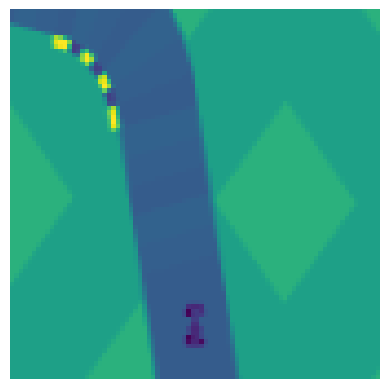

In [12]:
# Action mapping from gymnasium.farama.org
action_mapping = {
    0: "do nothing",
    1: "steer left",
    2: "steer right",
    3: "gas",
    4: "brake"
}

# Visualize random frames
idx = np.random.randint(len(dataset))
state, action = dataset[idx]
# store a single frame as we need it later for exporting an ONNX model (it needs a sample of the input for the export)
sample_state = torch.Tensor(state).unsqueeze(0).to(device)
# Display the sample
print(f"Action: {action_mapping[action]}")
plt.axis("off")
plt.imshow(state[0]);

In [13]:
# release memory
del dataset

# Define Policy Network

You need to design a neural network architecture that is capable of mapping a state to an action.
The input is a single image with the following properties:
- Resolution of 84x84 pixels
- Grayscale (meaning a single channel as opposed to three channels of an RGB image)
- The values of each pixel should be between 0 and 1

The output of the network should be one unit per possible action, as our environment has 5 actions that results in 5 output units.
Your network must implement the forward function in order to be compatible with the evaluation script.

In [14]:
from __future__ import annotations
import torchvision


def set_submodule(module: torch.nn.Module, submodule_path: str, submodule: torch.nn.Module) -> None:
    *parent_path, attr_name = submodule_path.split(".")
    parent = module
    for child in parent_path:
        parent = getattr(parent, child)
    setattr(parent, attr_name, submodule)


class PolicyNetwork(nn.Module):
    """
    Policy network is compatible with any CNN architecture as long as:
    1) One of the conv layers determines how many channels it can process
    2) One of the linear layers determines the number of output neurons
    
    This should be enough to support all standard architectures

    >>> policy_nn = PolicyNetwork(
    ...     actions=5,
    ...     architecture="efficientnet_b0",
    ...     input_conv="features.0.0",
    ...     output_lin="classifier.1",
    ...     pretrained_weights=None, # "IMAGENET1K_V1"
    ... )
    >>> inputs = torch.rand(size=(16, 1, 64, 64))
    >>> policy_nn(inputs).shape
    torch.Size([16, 5])

    """

    def __init__(
        self,
        actions: int | dict[int, str],
        architecture: str,
        input_conv: str,
        output_lin: str,
        pretrained_weights = None,
        seed: int = 42,
    ) -> None:
        super(PolicyNetwork, self).__init__()
        if isinstance(actions, int):
            self.n_units_out = actions
            self.actions = {i: f"action_{i}" for i in range(actions)}
        else:
            self.n_units_out = len(actions)
            self.actions = actions
        self.architecture = architecture
        self.input_conv = input_conv
        self.output_lin = output_lin
        self.init(pretrained_weights, seed)

    def init(self, pretrained_weights = None, seed: int = None) -> None:
        """
        Initializes the model parameters, either randomly or with pretrained weights.
        Patches the architecture to have desired input and output shape.
        """
        if seed is not None:
            torch.random.manual_seed(seed)
        self.cnn = torchvision.models.get_model(self.architecture, weights=pretrained_weights)
        self._patch_input_shape()
        self._patch_output_shape()

    def _patch_input_shape(self) -> None:
        "Make the architecture accept a single (grayscale) channel"
        old_in_conv = self.cnn.get_submodule(self.input_conv)
        assert isinstance(old_in_conv, torch.nn.Conv2d)
        new_in_conv = torch.nn.Conv2d(
            in_channels = 1, 
            out_channels = old_in_conv.out_channels,
            kernel_size = old_in_conv.kernel_size,
            stride = old_in_conv.stride,
            padding = old_in_conv.padding,
            bias = old_in_conv.bias is not None,
        )
        set_submodule(self.cnn, self.input_conv, new_in_conv)

    def _patch_output_shape(self) -> None:
        "Make the architecture output the correct shape"
        old_out_lin = self.cnn.get_submodule(self.output_lin)
        assert isinstance(old_out_lin, torch.nn.Linear)
        new_out_lin = torch.nn.Linear(
            in_features = old_out_lin.in_features,
            out_features = self.n_units_out,
            bias = old_out_lin.bias is not None,
        )
        set_submodule(self.cnn, self.output_lin, new_out_lin)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # select only last channel if there are more
        x = x[:, (-1,), :, :]
        return self.cnn(x)

# Train behavioral cloning policy

Now that you have a Dataset and a network you need to train your network.
With behavioral cloning we want to imitate the behavior of the agent that produced the demonstration dataset as close as possible.
This is basically supervised learning, where you want to minimize the loss of your network on the training and validation sets.

Some tips as to what you need to implement:
- choose the appropriate loss function (think on which kind of problem you are solving)
- choose an optimizer and its hyper-parameters
- optional: use a learning-rate scheduler
- don't forget to evaluate your network on the validation set
- store your model and training progress often so you don't loose progress if your program crashes


In [15]:
class CropObservation(gym.ObservationWrapper):
    def __init__(self, env, shape):
        gym.ObservationWrapper.__init__(self, env)
        self.shape = shape
        obs_shape = self.shape + env.observation_space.shape[2:]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def observation(self, observation):
        return observation[:self.shape[0], :self.shape[1]]

    
class RecordState(gym.Wrapper):
    def __init__(self, env: gym.Env, enabled, reset_clean: bool = True):
        gym.Wrapper.__init__(self, env)

        assert env.render_mode is not None
        self.frame_list = []
        self.reset_clean = reset_clean
        self.enabled = enabled

    def step(self, action, **kwargs):
        output = self.env.step(action, **kwargs)
        if self.enabled:
            self.frame_list.append(output[0])
        return output

    def reset(self, *args, **kwargs):
        result = self.env.reset(*args, **kwargs)

        if self.reset_clean:
            self.frame_list = []
        if self.enabled:
            self.frame_list.append(result[0])

        return result

    def render(self):
        frames = self.frame_list
        self.frame_list = []
        return frames
    

class Agent():
    def __init__(self, model, device, supports_batch):
        self.model = model
        self.device = device
        self.supports_batch = supports_batch

    def select_action(self, state):
        if not isinstance(state, torch.Tensor):
            state = torch.tensor(state)

        if not self.supports_batch and state.ndim == 4 and state.shape[0] > 1:
            return np.stack([self.select_action(s) for s in state])

        with torch.no_grad():
            self.model.eval().to(self.device)
            state = state.to(self.device) / 255.0 # rescale
            if len(state.shape) == 3:
              state = state.unsqueeze(0)
            logits = self.model(state)
            if type(logits) is tuple:
                logits = logits[0]
            probs = Categorical(logits=logits)
            selected = probs.sample().cpu().numpy()
            if selected.size == 1:
                return selected.item()
            return selected
        
            
def make_env(seed, capture_video=True, enabled_record_state=False, video_dir=None):
    env = gym.make("CarRacing-v2", render_mode="rgb_array", continuous=False)
    env = gym.wrappers.RecordEpisodeStatistics(env)
    if capture_video:
        os.makedirs(video_dir, exist_ok=True)
        env = gym.wrappers.RecordVideo(env, video_dir)   
    env = CropObservation(env, (84, 96))
    env = gym.wrappers.ResizeObservation(env, (84, 84))
    env = gym.wrappers.GrayScaleObservation(env)    
    env = RecordState(env, reset_clean=True, enabled=enabled_record_state)
    env = gym.wrappers.FrameStack(env, 4)
    env.reset(seed=seed)
    env.action_space.seed(seed)
    env.observation_space.seed(seed)
    return env


def run_episode(agent: Agent, show_progress=True, capture_video=True, seed=None, video_dir=None):
    if capture_video:
        assert video_dir is not None

    env: gym.Env = make_env(seed=seed, capture_video=capture_video, video_dir=video_dir)
    state, _ = env.reset()
    score = 0
    done = False
    if show_progress:
        progress = tqdm(desc="Score: 0")
        
    while not done:
        action = agent.select_action(state[-1][np.newaxis, ...])
        state, reward, terminated, truncated, _ = env.step(action)
        score += reward
        done = terminated or truncated
        if show_progress:
            progress.update()
            progress.set_description("Score: {:.2f}".format(score))       
    env.close()
    
    if show_progress:
        progress.close()    
    if capture_video:
        show_video_from_folder(video_dir)
    
    return score

In [16]:
# ! pip install \
#   lovely-tensors==0.1.14 \
#   lovely-numpy==0.2.8 \
#   lightning==2.0.0 \
# 1> /dev/null

In [17]:
import lovely_tensors
import lovely_numpy

def lovely(x):
    "summarizes important tensor properties"
    if isinstance(x, np.ndarray):
        return lovely_numpy.lovely(x)
    return lovely_tensors.lovely(x)

In [18]:
from typing import Iterable

def measure_scores_parallel(agent: Agent, num_episodes: int, limit_steps: int = None, return_unfinished: bool = False) -> Iterable[float]:
    env = gym.vector.AsyncVectorEnv([
        lambda: make_env(seed=None, capture_video=False)
        for _ in range(num_episodes)
    ])
    
    if limit_steps is None:
        limit_steps = env.get_attr("spec")[0].max_episode_steps
    if limit_steps is None:
        raise ValueError("limit_steps must not be None")

    state, _ = env.reset()
    score = np.zeros(num_episodes)
    done = np.zeros(num_episodes, dtype=bool)

    for i in tqdm(range(limit_steps), "Measuring score - step"):
        action = agent.select_action(state)
        state, reward, terminated, truncated, _ = env.step(action)
        # don't update score of episodes that ended already
        # vector env resets them automatically and starts over
        score[~done] += reward[~done]
        curr_ended = terminated | truncated
        done |= curr_ended
        for idx in curr_ended.nonzero()[0]:
            yield score[idx].item()

        if done.all():
            break
      
    env.close()

    if return_unfinished:
        yield from score[~done].tolist()


In [19]:
import lightning

class MetricsHistoryKeeper(lightning.Callback):
    def __init__(self):
        super().__init__()
        self.history = []

    def on_validation_epoch_end(self, trainer, pl_module):
        metrics = {}
        for key, value in trainer.callback_metrics.items():
            if isinstance(value, torch.Tensor):
                value = value.cpu().numpy()
            if isinstance(value, np.ndarray) and value.size == 1:
                value = value.item()
            metrics[key] = value
        self.history.append(metrics)

In [20]:
import pandas as pd

def cvar(scores: np.ndarray | pd.Series, *, percent: float) -> float:
    """
    Computes conditional value at risk (CVaR) of a given set of scores.
    CVaR is the expected value of the worst percents of the scores.
    """
    assert 0 < percent < 100
    if not isinstance(scores, pd.Series):
        scores = pd.Series(scores)
    quantile = scores.quantile(percent / 100)
    return scores[scores <= quantile].mean()
    
cvar(np.arange(100), percent=25)

12.0

In [21]:
from __future__ import annotations

import time
import copy
import pathlib

import wandb
from typing import Any
from tqdm.auto import tqdm

class LightningPolicyNetwork(lightning.LightningModule):
    
    def __init__(
        self,
        model_config: dict[str, Any],
        num_val_episodes: int,
        limit_val_steps: int | None,
        label_smoothing: float,
        dummy_score_during_sanity_check: float | None,
        desired_score: float = None,
    ) -> None:

        super().__init__()
        self.save_hyperparameters()
        self.model_config = model_config
        self.num_val_episodes = num_val_episodes
        self.limit_val_steps = limit_val_steps
        self.desired_score = desired_score
        self.dummy_score_during_sanity_check = dummy_score_during_sanity_check

        self.model = PolicyNetwork(**model_config, pretrained_weights=None)
        self.loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=label_smoothing)
        self.loss_name = "cross_entropy_loss"

        self.simulation_test_kwargs = None

    def configure_optimizers(self) -> torch.optim.Optimizer:
        return torch.optim.Adam(self.parameters(), lr=1e-4)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)

    @staticmethod
    def _entropy(logits: torch.Tensor) -> torch.Tensor:
        return -(logits.softmax(dim=-1) * logits.log_softmax(dim=-1)).sum(dim=-1).mean()

    def training_step(self, batch: tuple[torch.Tensor, torch.Tensor], batch_idx) -> torch.Tensor:
        state, action = batch
        logits = self(state)
        loss = self.loss_fn(logits, action)
        self.log_dict({
            "train/" + self.loss_name: loss,
            "train/entropy": self._entropy(logits)
        })
        return loss
    
    def validation_step(self, batch: tuple[torch.Tensor, torch.Tensor], batch_idx) -> torch.Tensor:
        state, action = batch
        logits: torch.Tensor = self(state)
        loss = self.loss_fn(logits, action)
        accuracy = (logits.argmax(dim=-1) == action).float().mean()
        self.log_dict({
            "valid/" + self.loss_name: loss,
            "valid/entropy": self._entropy(logits),
            "valid/accuracy": accuracy,
        })
        return loss

    def test_in_simulation(self, num_episodes: int, limit_steps: int, return_unfinished: bool, log: bool, device = None) -> np.ndarray:
        if device is None:
            device = self.device
        agent = Agent(self.model, device, supports_batch=True)
        scores = measure_scores_parallel(agent, num_episodes, limit_steps, return_unfinished)
        scores = np.array(list(scores))
        if log:
            self.log_simulation_metrics(scores, limit_steps, return_unfinished)
        return scores

    def simulation_metrics(self, scores: np.ndarray) -> dict[str, Any]:
        basic = {
            "num_episodes": float(len(scores)),
            "score_avg": float(scores.mean()),
            "score_std": float(scores.std()),
            "score_min": float(scores.min()),
            "score_max": float(scores.max())
        }
        percentiles = {
            f"score_percentile_{p}": pd.Series(scores).quantile(p / 100)
            for p in [25, 50, 75]
        }
        cvars = {
            f"score_cvar_{p}": cvar(scores, percent=p)
            for p in [25, 50, 75]
        }
        return {**basic, **cvars, **percentiles}

    def log_simulation_metrics(self, scores: np.ndarray, limit_steps: int, return_unfinished: bool) -> dict[str, Any]:
        prefix = "simulation" if limit_steps is None else "simulation_limited"

        for logger in self.loggers:
            if not isinstance(logger, lightning.pytorch.loggers.WandbLogger):
                continue
            logger.log_metrics({f"{prefix}/score": wandb.Histogram(scores)})

        self.log_dict({
            f"{prefix}/{name}": value
            for name, value in self.simulation_metrics(scores).items()
        })

        self.log_dict({
            f"{prefix}/limit_steps": -1.0 if limit_steps is None else float(limit_steps),
            f"{prefix}/return_unfinished": 1.0 if return_unfinished else 0.0,
            f"{prefix}/was_sanity_check": 1.0 if self.trainer.sanity_checking else 0.0,
        })

        if not self.trainer.sanity_checking:
            print("Simulation score average:", scores.mean())

            if self.desired_score is not None and scores.mean() < self.desired_score:
                print("Gotta pump those numbers up. Those are rookie numbers in this racket.")

    def on_validation_epoch_end(self) -> None:
        if self.trainer.sanity_checking:
            limit_steps = 10
        else:
            limit_steps = self.limit_val_steps

        return_unfinished = True
        scores = self.test_in_simulation(self.num_val_episodes, limit_steps, return_unfinished, log=False)

        if self.trainer.sanity_checking and self.dummy_score_during_sanity_check is not None:
            scores = np.full(self.num_val_episodes, self.dummy_score_during_sanity_check, dtype=float)
            limit_steps = 0
            return_unfinished = False

        self.log_simulation_metrics(scores, limit_steps, return_unfinished)

    def prepare_testing(self, **kwargs: Any) -> None:
        self.simulation_test_kwargs = kwargs

    def test_step(self, *args: Any, **kwargs: Any) -> None:
        print("test step: IGNORING input")
    
    def on_test_epoch_end(self):
         return self.test_in_simulation(**self.simulation_test_kwargs, log=True)


class MyDataModule(lightning.LightningDataModule):
    def __init__(self, train_set: DemonstrationDataset, val_set: DemonstrationDataset, batch_size: int, num_workers: int, prefetch_factor: int, pin_memory: int):
        super().__init__()
        self.batch_size = batch_size
        self.train_set = train_set
        self.val_set = val_set
        self.num_workers = num_workers
        self.prefetch_factor = prefetch_factor
        self.pin_memory = pin_memory

    def train_dataloader(self):
        print(f"RELOADING TRAIN DATALOADER. dataset size = {len(self.train_set)}")
        return torch.utils.data.DataLoader(
            self.train_set,
            shuffle=True,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            prefetch_factor=self.prefetch_factor,
            pin_memory=self.pin_memory,
        )

    def val_dataloader(self):
        return torch.utils.data.DataLoader(
            self.val_set,
            shuffle=False,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            prefetch_factor=self.prefetch_factor,
            pin_memory=self.pin_memory,
        )


In [22]:
TRAIN_SUPERVISED = False

In [23]:
model_config = dict(
    actions=action_mapping,
    architecture="efficientnet_b0",
    input_conv="features.0.0",
    output_lin="classifier.1",
)

if TRAIN_SUPERVISED:

    train_set = DemonstrationDataset("train")
    val_set = DemonstrationDataset("val")

    os.makedirs("wandb", exist_ok=True)
    wandb_logger = lightning.pytorch.loggers.WandbLogger(
        project="jku-deep-rl_imitation-learning",
        save_dir="wandb",
    )

    # selecting the best model according to it's average of 60% worst scores
    # this prefers models that are consistent in a good performance
    checkpointing = lightning.pytorch.callbacks.ModelCheckpoint(
        monitor="simulation/score_cvar_50",
        mode="max",
        save_last=True,
        save_top_k=10,
        dirpath=f"checkpoints/{wandb_logger.experiment.name}/",
        filename="step={step}_score-avg={simulation/score_avg:.2f}_score-cvar-50={simulation/score_cvar_50:.2f}",
        auto_insert_metric_name=False,
    )

    metrics_history_keeper = MetricsHistoryKeeper()

    lightning_model = LightningPolicyNetwork(
        model_config,
        num_val_episodes=8,
        limit_val_steps=None,
        label_smoothing=0.01,
        dummy_score_during_sanity_check=0,
        desired_score=650,
    )

    wandb_logger.experiment.config.update({
        "dagger_enabled": False,
    })

    datamodule = MyDataModule(
        train_set=train_set,
        val_set=val_set,
        num_workers=16,
        batch_size=128,
        prefetch_factor=8,
        pin_memory=True,
    )

    num_batches = len(train_set) / datamodule.batch_size

    trainer = lightning.Trainer(
        logger=wandb_logger,
        val_check_interval=int(0.5 * num_batches),
        max_epochs=3,
        precision="16-mixed",
        accelerator="cuda",
        devices=devices,
        callbacks=[
            checkpointing,
            metrics_history_keeper,
        ],
    )


In [24]:
if TRAIN_SUPERVISED:
    trainer.fit(
        lightning_model,
        datamodule
    )

In [25]:
if TRAIN_SUPERVISED:
    lightning_model = LightningPolicyNetwork.load_from_checkpoint(checkpointing.best_model_path)

    # If you want to export your model as an ONNX file use the following code as template
    save_as_onnx(
        lightning_model.model.to("cpu"),
        sample_state.to("cpu"),
        pathlib.Path(checkpointing.best_model_path).with_suffix(".onnx"),
    )

# Evaluate the agent in the real environment

### Environment and Agent

We provide some wrappers you need in order to get the same states from the environment as in the demonstration dataset.
Additionally the `RecordState` wrapper should be very helpful in collecting new samples for the DAgger algorithm.

## Evaluate behavioral cloning agent

In [26]:
from IPython.display import display

In [27]:
if TRAIN_SUPERVISED:
    history = pd.DataFrame(metrics_history_keeper.history)
    display(history)

In [28]:
if TRAIN_SUPERVISED:
    best_point = history["simulation/score_avg"].idxmax()
    display(history.loc[best_point])

Let's see how the agent is doing in the real environment

In [29]:
if TRAIN_SUPERVISED:
    lightning_model.prepare_testing(num_episodes=8, limit_steps=None, return_unfinished=False)
    metrics = trainer.test(lightning_model, torch.utils.data.DataLoader([0]))[0]
    display(metrics)

In [30]:
if TRAIN_SUPERVISED:
    video_dir = f"videos/{wandb_logger.experiment.name}/{datetime.datetime.now().isoformat()}"
    score = run_episode(
        agent=Agent(lightning_model.model, device=device, supports_batch=True),
        capture_video=True, 
        video_dir=video_dir,
    )
    wandb.log({
        "simulation_run": wandb.Video(f"{video_dir}/rl-video-episode-0.mp4")
    })
    print(f"Score: {score:.2f}")

In [31]:
if TRAIN_SUPERVISED:
    wandb_logger.experiment.finish()

# DAGGER

Now we can implement DAgger, you have downloaded a relatively well trained model you can use as an expert for this purpose.

Load expert model that is provided as ONNX file.

## Load the expert

In [32]:
# Load expert
expert_model = ConvertModel(onnx.load("expert.onnx"))

# Freeze expert weights
for p in expert_model.parameters():
    p.requires_grad_(False)
    
expert_agent = Agent(expert_model, device, supports_batch=False)

/var/tmp/xkadlci2/.conda/envs/drl-imitation-learning/lib/python3.8/site-packages/onnx2pytorch/convert/layer.py:30: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525541702/work/torch/csrc/utils/tensor_numpy.cpp:199.)
  layer.weight.data = torch.from_numpy(numpy_helper.to_array(weight))


Next, you have to implement the DAgger algorithm (see slides for details). This function implements the core idea of DAgger:


1. Choose the policy with probability beta
2. Sample T-step trajectories using this policy
3. Label the gathered states with the expert

The aggregation and training part are already implemented.

In [33]:
from __future__ import annotations
import itertools


def collect_data_parallel(
    train_agent: Agent,
    expert_agent: Agent,
    num_parallel_envs: int,
    each_env_num_steps: int,
    switch_expert_steps: int,
    switch_train_steps: int,
    single_frame: bool = True,
) -> Iterable[tuple[np.ndarray, np.ndarray]]:
    """
    Yields:
      state: np.ndarray of shape observation_shape
      action: np.ndarray scalar
    in total it yields (num_parallel_envs * each_env_num_steps) times

    It follows the expert for for switch_expert_steps steps, then it follows
    the train_agent for switch_train_steps steps and repeats this cycle.
    """

    env = gym.vector.AsyncVectorEnv([
        lambda: make_env(seed=None, capture_video=False)
        for _ in range(num_parallel_envs)
    ])
    
    if each_env_num_steps is None:
        each_env_num_steps = env.get_attr("spec")[0].max_episode_steps
    if each_env_num_steps is None:
        raise ValueError("num_steps must not be None")

    follow_expert = itertools.cycle(
        itertools.chain(
            itertools.repeat(True, switch_expert_steps),
            itertools.repeat(False, switch_train_steps),
        )
    )

    states, _ = env.reset()
    for i in tqdm(range(each_env_num_steps), desc="Collecting data - step"):
        expert_actions = expert_agent.select_action(states)
        if next(follow_expert):
            actions = expert_actions
        else:
            actions = train_agent.select_action(states)
        states, rewards, terminateds, truncateds, _ = env.step(actions)
        if single_frame:
            states_out = states[:, (-1,), :, :]
        else:
            states_out = states
        yield from zip(states_out, expert_actions)


    env.close()


In [34]:
class DaggerDataCollectionCallback(lightning.Callback):
    def __init__(
        self,
        train_set: DemonstrationDataset,
        device: torch.device,
        expert_agent: Agent,
        collect_every_nth_epoch: int,
        num_parallel_envs: int,
        each_env_num_steps: int,
        switch_expert_steps: int,
        switch_train_steps: int,
    ) -> None:
        self.train_set = train_set
        self.device = device
        self.expert_agent = expert_agent
        self.collect_every_nth_epoch = collect_every_nth_epoch
        self.num_parallel_envs = num_parallel_envs
        self.each_env_num_steps = each_env_num_steps
        self.switch_expert_steps = switch_expert_steps
        self.switch_train_steps = switch_train_steps
        self.duration_wall_time = 0.0
        self.duration_process_time = 0.0

    def setup(self, trainer: lightning.Trainer, lightning_model: lightning.LightningModule, stage: str) -> None:
        if trainer.reload_dataloaders_every_n_epochs == 0:
            raise ValueError(
                f"{self.__class__.__name__} requires"
                "`trainer.reload_dataloaders_every_n_epochs` to be a positive integer, ideally 1 "
                "to make use of new data collected by the callback."
            )

    def on_train_epoch_start(self, trainer: lightning.Trainer, lightning_model: lightning.LightningModule) -> None:
        lightning_model.log_dict({
            "dagger/dataset_size": float(len(self.train_set)),
            "dagger/collect_data_wall_seconds": self.duration_wall_time,
            "dagger/collect_data_process_seconds": self.duration_process_time,
            "dagger/num_parallel_envs": float(self.num_parallel_envs),
            "dagger/each_env_num_steps": float(self.each_env_num_steps),
            "dagger/switch_expert_steps": float(self.switch_expert_steps),
            "dagger/switch_train_steps": float(self.switch_train_steps),
            "dagger/num_parallel_envs": float(self.num_parallel_envs),
        })

    def on_train_epoch_end(self, trainer: lightning.Trainer, lightning_model: LightningPolicyNetwork) -> None:
        if self.collect_every_nth_epoch is None:
            return
        if trainer.current_epoch % self.collect_every_nth_epoch != 0:
            return
        if trainer.current_epoch == trainer.max_epochs - 1:
            return

        train_agent = Agent(lightning_model.model, self.device, supports_batch=True)
        start_wall_time = time.time()
        start_process_time = time.process_time()

        self.train_set.append_iterable(
            collect_data_parallel(
                train_agent,
                self.expert_agent,
                self.num_parallel_envs,
                self.each_env_num_steps,
                self.switch_expert_steps,
                self.switch_train_steps,
            )
        )

        self.duration_wall_time = time.time() - start_wall_time
        self.duration_process_time = time.process_time() - start_process_time


Put everything together now. 
1. Create new samples using the DAgger algorithm
2. Continue training your agent
3. Export your fully trained agent as an ONNX file

In [35]:
train_set = DemonstrationDataset("train")
val_set = DemonstrationDataset("val")

wandb_logger = lightning.pytorch.loggers.WandbLogger(
    project="jku-deep-rl_imitation-learning",
    save_dir="wandb",
)

checkpointing = lightning.pytorch.callbacks.ModelCheckpoint(
    monitor="simulation/score_cvar_50",
    mode="max",
    save_last=True,
    save_top_k=10,
    dirpath=f"checkpoints/{wandb_logger.experiment.name}/",
    filename="step={step}_score-avg={simulation/score_avg:.2f}_score-cvar-50={simulation/score_cvar_50:.2f}",
    auto_insert_metric_name=False,
)

metrics_history_keeper = MetricsHistoryKeeper()

lightning_model = LightningPolicyNetwork(
    model_config,
    num_val_episodes=16,
    limit_val_steps=None,
    label_smoothing=0.01,
    dummy_score_during_sanity_check=0,
    desired_score=650,
)

datamodule = MyDataModule(
    train_set=train_set,
    val_set=val_set,
    num_workers=16,
    batch_size=128,
    prefetch_factor=8,
    pin_memory=True,
)

dagger_config = dict(
    collect_every_nth_epoch=1,
    num_parallel_envs=8,
    each_env_num_steps=4000,
    switch_expert_steps=35,
    switch_train_steps=5,
)

dagger_data_collection_callback = DaggerDataCollectionCallback(
    train_set=train_set,
    expert_agent=expert_agent,
    device=device,
    **dagger_config
)

wandb_logger.experiment.config.update({
    "dagger_enabled": True,
    "dagger_config": dagger_config,
})

num_batches = int(len(train_set) / datamodule.batch_size)

trainer = lightning.Trainer(
    logger=wandb_logger,
    val_check_interval=num_batches,
    reload_dataloaders_every_n_epochs=1,
    max_epochs=10,
    precision="16-mixed",
    accelerator="cuda",
    devices=devices,
    callbacks=[
        checkpointing,
        metrics_history_keeper,
        dagger_data_collection_callback, # CRUCIAL !!!
    ],
)


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Loaded dataset with 49538 demonstrations
Loaded dataset with 9458 demonstrations


wandb: Currently logged in as: markcheeky. Use `wandb login --relogin` to force relogin


Using 16bit Automatic Mixed Precision (AMP)


GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


In [36]:
trainer.fit(lightning_model, datamodule=datamodule)

You are using a CUDA device ('NVIDIA A40') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9,10,11,12]



  | Name    | Type             | Params
---------------------------------------------
0 | model   | PolicyNetwork    | 4.0 M 
1 | loss_fn | CrossEntropyLoss | 0     
---------------------------------------------
4.0 M     Trainable params
0         Non-trainable params
4.0 M     Total params
16.054    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Measuring score - step:   0%|          | 0/10 [00:00<?, ?it/s]

RELOADING TRAIN DATALOADER. dataset size = 49538


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Measuring score - step:   0%|          | 0/1000 [00:00<?, ?it/s]

Simulation score average: 732.7054911918228


RELOADING TRAIN DATALOADER. dataset size = 81538


Validation: 0it [00:00, ?it/s]

Measuring score - step:   0%|          | 0/1000 [00:00<?, ?it/s]

Simulation score average: 591.5444218748906
Gotta pump those numbers up. Those are rookie numbers in this racket.


RELOADING TRAIN DATALOADER. dataset size = 113538


Validation: 0it [00:00, ?it/s]

Measuring score - step:   0%|          | 0/1000 [00:00<?, ?it/s]

Simulation score average: 617.2108560692833
Gotta pump those numbers up. Those are rookie numbers in this racket.


Validation: 0it [00:00, ?it/s]

Measuring score - step:   0%|          | 0/1000 [00:00<?, ?it/s]

Simulation score average: 681.600311467649


RELOADING TRAIN DATALOADER. dataset size = 145538


Validation: 0it [00:00, ?it/s]

Measuring score - step:   0%|          | 0/1000 [00:00<?, ?it/s]

Simulation score average: 781.6362600016798


Validation: 0it [00:00, ?it/s]

Measuring score - step:   0%|          | 0/1000 [00:00<?, ?it/s]

Simulation score average: 704.8286946267333


RELOADING TRAIN DATALOADER. dataset size = 177538


Validation: 0it [00:00, ?it/s]

Measuring score - step:   0%|          | 0/1000 [00:00<?, ?it/s]

Simulation score average: 670.329276067609


Validation: 0it [00:00, ?it/s]

Measuring score - step:   0%|          | 0/1000 [00:00<?, ?it/s]

Simulation score average: 729.6687957407153


Validation: 0it [00:00, ?it/s]

Measuring score - step:   0%|          | 0/1000 [00:00<?, ?it/s]

Simulation score average: 747.509865755784


RELOADING TRAIN DATALOADER. dataset size = 209538


Validation: 0it [00:00, ?it/s]

Measuring score - step:   0%|          | 0/1000 [00:00<?, ?it/s]

Simulation score average: 621.868510057257
Gotta pump those numbers up. Those are rookie numbers in this racket.


Validation: 0it [00:00, ?it/s]

Measuring score - step:   0%|          | 0/1000 [00:00<?, ?it/s]

Simulation score average: 633.8933828184129
Gotta pump those numbers up. Those are rookie numbers in this racket.


Validation: 0it [00:00, ?it/s]

Measuring score - step:   0%|          | 0/1000 [00:00<?, ?it/s]

Simulation score average: 703.5345803426628


Validation: 0it [00:00, ?it/s]

Measuring score - step:   0%|          | 0/1000 [00:00<?, ?it/s]

Simulation score average: 466.7110407931628
Gotta pump those numbers up. Those are rookie numbers in this racket.


RELOADING TRAIN DATALOADER. dataset size = 241538


Validation: 0it [00:00, ?it/s]

Measuring score - step:   0%|          | 0/1000 [00:00<?, ?it/s]

Simulation score average: 605.6724574642734
Gotta pump those numbers up. Those are rookie numbers in this racket.


Validation: 0it [00:00, ?it/s]

Measuring score - step:   0%|          | 0/1000 [00:00<?, ?it/s]

Simulation score average: 548.0699312801919
Gotta pump those numbers up. Those are rookie numbers in this racket.


Validation: 0it [00:00, ?it/s]

Measuring score - step:   0%|          | 0/1000 [00:00<?, ?it/s]

Simulation score average: 667.8012117436524


Validation: 0it [00:00, ?it/s]

Measuring score - step:   0%|          | 0/1000 [00:00<?, ?it/s]

Simulation score average: 492.507054856505
Gotta pump those numbers up. Those are rookie numbers in this racket.


RELOADING TRAIN DATALOADER. dataset size = 273538


Validation: 0it [00:00, ?it/s]

Measuring score - step:   0%|          | 0/1000 [00:00<?, ?it/s]

Simulation score average: 454.4317525853851
Gotta pump those numbers up. Those are rookie numbers in this racket.


Validation: 0it [00:00, ?it/s]

Measuring score - step:   0%|          | 0/1000 [00:00<?, ?it/s]

Simulation score average: 632.7132793399516
Gotta pump those numbers up. Those are rookie numbers in this racket.


Validation: 0it [00:00, ?it/s]

Measuring score - step:   0%|          | 0/1000 [00:00<?, ?it/s]

Simulation score average: 731.1083141897018


Validation: 0it [00:00, ?it/s]

Measuring score - step:   0%|          | 0/1000 [00:00<?, ?it/s]

Simulation score average: 554.9118745408271
Gotta pump those numbers up. Those are rookie numbers in this racket.


Validation: 0it [00:00, ?it/s]

Measuring score - step:   0%|          | 0/1000 [00:00<?, ?it/s]

Simulation score average: 513.2640100737489
Gotta pump those numbers up. Those are rookie numbers in this racket.


RELOADING TRAIN DATALOADER. dataset size = 305538


Validation: 0it [00:00, ?it/s]

Measuring score - step:   0%|          | 0/1000 [00:00<?, ?it/s]

Simulation score average: 601.1684679033707
Gotta pump those numbers up. Those are rookie numbers in this racket.


Validation: 0it [00:00, ?it/s]

Measuring score - step:   0%|          | 0/1000 [00:00<?, ?it/s]

Simulation score average: 554.1268427176765
Gotta pump those numbers up. Those are rookie numbers in this racket.


Validation: 0it [00:00, ?it/s]

Measuring score - step:   0%|          | 0/1000 [00:00<?, ?it/s]

Simulation score average: 601.6865022579094
Gotta pump those numbers up. Those are rookie numbers in this racket.


Validation: 0it [00:00, ?it/s]

Measuring score - step:   0%|          | 0/1000 [00:00<?, ?it/s]

Simulation score average: 568.3668785094928
Gotta pump those numbers up. Those are rookie numbers in this racket.


Validation: 0it [00:00, ?it/s]

Measuring score - step:   0%|          | 0/1000 [00:00<?, ?it/s]

Simulation score average: 583.6984651785399
Gotta pump those numbers up. Those are rookie numbers in this racket.


Validation: 0it [00:00, ?it/s]

Measuring score - step:   0%|          | 0/1000 [00:00<?, ?it/s]

Simulation score average: 525.606179971614
Gotta pump those numbers up. Those are rookie numbers in this racket.


RELOADING TRAIN DATALOADER. dataset size = 337538


Validation: 0it [00:00, ?it/s]

Measuring score - step:   0%|          | 0/1000 [00:00<?, ?it/s]

Simulation score average: 508.1352019475574
Gotta pump those numbers up. Those are rookie numbers in this racket.


Validation: 0it [00:00, ?it/s]

Measuring score - step:   0%|          | 0/1000 [00:00<?, ?it/s]

Simulation score average: 553.741307336489
Gotta pump those numbers up. Those are rookie numbers in this racket.


Validation: 0it [00:00, ?it/s]

Measuring score - step:   0%|          | 0/1000 [00:00<?, ?it/s]

Simulation score average: 500.09264915331505
Gotta pump those numbers up. Those are rookie numbers in this racket.


Validation: 0it [00:00, ?it/s]

Measuring score - step:   0%|          | 0/1000 [00:00<?, ?it/s]

Simulation score average: 615.2949335232637
Gotta pump those numbers up. Those are rookie numbers in this racket.


Validation: 0it [00:00, ?it/s]

Measuring score - step:   0%|          | 0/1000 [00:00<?, ?it/s]

Simulation score average: 496.62432225451937
Gotta pump those numbers up. Those are rookie numbers in this racket.


Validation: 0it [00:00, ?it/s]

Measuring score - step:   0%|          | 0/1000 [00:00<?, ?it/s]

Simulation score average: 628.2971808861721
Gotta pump those numbers up. Those are rookie numbers in this racket.


`Trainer.fit` stopped: `max_epochs=10` reached.


In [37]:
lightning_model = LightningPolicyNetwork.load_from_checkpoint(checkpointing.best_model_path)

In [38]:
# If you want to export your model as an ONNX file use the following code as template
# If you use the provided logger you can use this directly
save_as_onnx(
    lightning_model.model.to("cpu"),
    sample_state.to("cpu"),
    pathlib.Path(checkpointing.best_model_path).with_suffix(".onnx"),
)

In [39]:
history = pd.DataFrame(metrics_history_keeper.history)
history

,valid/cross_entropy_loss,valid/entropy,valid/accuracy,train/cross_entropy_loss,train/entropy,simulation/num_episodes,simulation/score_avg,simulation/score_std,simulation/score_min,simulation/score_max,...,simulation/limit_steps,simulation/return_unfinished,simulation/was_sanity_check,dagger/dataset_size,dagger/collect_data_wall_seconds,dagger/collect_data_process_seconds,dagger/num_parallel_envs,dagger/each_env_num_steps,dagger/switch_expert_steps,dagger/switch_train_steps
0,1.609335,1.609321,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.829761,0.786903,0.699937,0.846468,0.815624,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.820813,0.746332,0.704166,0.835521,0.756963,16.0,732.705505,227.201385,284.615387,923.000000,...,-1.0,1.0,0.0,49538.0,0.000000,0.000000,8.0,4000.0,35.0,5.0
3,0.818398,0.913203,0.703003,0.863924,0.875353,16.0,591.544434,196.919464,270.967743,907.299988,...,-1.0,1.0,0.0,81538.0,897.189514,31388.703125,8.0,4000.0,35.0,5.0
4,0.814412,0.765645,0.703108,0.775373,0.817213,16.0,617.210876,268.406738,-45.817730,918.500000,...,-1.0,1.0,0.0,81538.0,897.189514,31388.703125,8.0,4000.0,35.0,5.0
5,0.818951,0.780947,0.704694,0.719365,0.773376,16.0,681.600342,193.242950,277.358490,877.611938,...,-1.0,1.0,0.0,113538.0,1003.780823,24828.220703,8.0,4000.0,35.0,5.0
6,0.811514,0.738474,0.706915,0.605387,0.750683,16.0,781.636230,133.334000,464.625854,911.000000,...,-1.0,1.0,0.0,113538.0,1003.780823,24828.220703,8.0,4000.0,35.0,5.0
7,0.820983,0.787745,0.705435,0.837560,0.784571,16.0,704.828674,209.538177,244.213654,903.599976,...,-1.0,1.0,0.0,145538.0,906.240845,31419.843750,8.0,4000.0,35.0,5.0
8,0.816899,0.739783,0.703531,0.862391,0.779354,16.0,670.329285,179.108246,393.006989,910.500000,...,-1.0,1.0,0.0,145538.0,906.240845,31419.843750,8.0,4000.0,35.0,5.0
9,0.818945,0.770975,0.700677,0.793625,0.818535,16.0,729.668823,174.627319,349.101807,902.099976,...,-1.0,1.0,0.0,145538.0,906.240845,31419.843750,8.0,4000.0,35.0,5.0


In [40]:
best_point = history["simulation/score_avg"].idxmax()
history.loc[best_point]

valid/cross_entropy_loss                    0.811514
valid/entropy                               0.738474
valid/accuracy                              0.706915
train/cross_entropy_loss                    0.605387
train/entropy                               0.750683
simulation/num_episodes                    16.000000
simulation/score_avg                      781.636230
simulation/score_std                      133.334000
simulation/score_min                      464.625854
simulation/score_max                      911.000000
simulation/score_cvar_25                  578.437285
simulation/score_cvar_50                  677.016768
simulation/score_cvar_75                  739.948347
simulation/score_percentile_25            739.986886
simulation/score_percentile_50            821.082478
simulation/score_percentile_75            886.937094
simulation/limit_steps                     -1.000000
simulation/return_unfinished                1.000000
simulation/was_sanity_check                 0.

In [41]:
lightning_model.prepare_testing(num_episodes=16, limit_steps=None, return_unfinished=False)
metrics = trainer.test(lightning_model, torch.utils.data.DataLoader([0]))[0]

You are using a CUDA device ('NVIDIA A40') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9,10,11,12]


/var/tmp/xkadlci2/.conda/envs/drl-imitation-learning/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 80 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

test step: IGNORING input


Measuring score - step:   0%|          | 0/1000 [00:00<?, ?it/s]

Simulation score average: 695.8200093095124


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃          Test metric           ┃          DataLoader 0          ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     simulation/limit_steps     │              -1.0              │
│    simulation/num_episodes     │              16.0              │
│  simulation/return_unfinished  │              0.0               │
│      simulation/score_avg      │       695.8200073242188        │
│    simulation/score_cvar_25    │       464.87386236360203       │
│    simulation/score_cvar_50    │        567.308977897161        │
│    simulation/score_cvar_75    │       644.4677099159277        │
│      simulation/score_max      │       889.3238525390625        │
│      simulation/score_min      │       245.27687072753906       │
│ simulation/score_percentile_25 │       596.7645602525088        │
│ simulation/score_percentile_50 │       775.0615763546647        │
│ simulation/score_percentile_75 │       803.0677802762464        │
│      simulation/score_std      │       165.15821838378906       │
│  simulation/was_sanity_check   │              0.0               │
└────────────────────────────────┴────────────────────────────────┘

<span id="papermill-error-cell" style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">Execution using papermill encountered an exception here and stopped:</span>

In [42]:
video_dir = f"videos/{wandb_logger.experiment.name}/{datetime.datetime.now().isoformat()}"
score = run_episode(
    agent=Agent(lightning_model.model, device=device, supports_batch=True),
    capture_video=True, 
    video_dir=video_dir,
)
wandb.log({
    "simulation_run": wandb.Video(f"{video_dir}/rl-video-episode-0.mp4")
})
print(f"Score: {score:.2f}")

Score: 0: 0it [00:00, ?it/s]

Moviepy - Building video /home/xkadlci2/jku-deep-rl/hw1/videos/fallen-oath-87/2023-04-13T16:12:52.756988/rl-video-episode-0.mp4.
Moviepy - Writing video /home/xkadlci2/jku-deep-rl/hw1/videos/fallen-oath-87/2023-04-13T16:12:52.756988/rl-video-episode-0.mp4



t:   0%|                                                                                                                                                                 | 0/1002 [00:00<?, ?it/s, now=None]

t:   1%|█▊                                                                                                                                                     | 12/1002 [00:00<00:08, 119.13it/s, now=None]

t:   5%|███████▏                                                                                                                                               | 48/1002 [00:00<00:04, 209.84it/s, now=None]

t:   8%|███████████▉                                                                                                                                           | 79/1002 [00:00<00:03, 249.24it/s, now=None]

t:  12%|██████████████████                                                                                                                                    | 121/1002 [00:00<00:02, 308.78it/s, now=None]

t:  16%|████████████████████████▋                                                                                                                             | 165/1002 [00:00<00:02, 353.36it/s, now=None]

t:  21%|███████████████████████████████▍                                                                                                                      | 210/1002 [00:00<00:02, 384.01it/s, now=None]

t:  25%|█████████████████████████████████████▎                                                                                                                | 249/1002 [00:00<00:02, 375.55it/s, now=None]

t:  29%|███████████████████████████████████████████▎                                                                                                          | 289/1002 [00:00<00:01, 381.18it/s, now=None]

t:  33%|█████████████████████████████████████████████████                                                                                                     | 328/1002 [00:00<00:01, 376.04it/s, now=None]

t:  38%|█████████████████████████████████████████████████████████▏                                                                                            | 382/1002 [00:01<00:01, 423.10it/s, now=None]

t:  44%|█████████████████████████████████████████████████████████████████▋                                                                                    | 439/1002 [00:01<00:01, 466.70it/s, now=None]

t:  50%|██████████████████████████████████████████████████████████████████████████▍                                                                           | 497/1002 [00:01<00:01, 497.42it/s, now=None]

t:  55%|█████████████████████████████████████████████████████████████████████████████████▉                                                                    | 547/1002 [00:01<00:00, 494.97it/s, now=None]

t:  60%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 597/1002 [00:01<00:00, 464.51it/s, now=None]

t:  64%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 644/1002 [00:01<00:00, 429.74it/s, now=None]

t:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 688/1002 [00:01<00:00, 395.87it/s, now=None]

t:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 729/1002 [00:01<00:00, 386.71it/s, now=None]

t:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 781/1002 [00:01<00:00, 421.74it/s, now=None]

t:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 831/1002 [00:02<00:00, 441.54it/s, now=None]

t:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 884/1002 [00:02<00:00, 464.63it/s, now=None]

t:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 938/1002 [00:02<00:00, 485.47it/s, now=None]

t:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 991/1002 [00:02<00:00, 497.34it/s, now=None]

Moviepy - Done !
Moviepy - video ready /home/xkadlci2/jku-deep-rl/hw1/videos/fallen-oath-87/2023-04-13T16:12:52.756988/rl-video-episode-0.mp4


AttributeError: 'function' object has no attribute 'display'

In [ ]:
wandb_logger.experiment.finish()